### **O problema**

Você foi recentemente alocado em uma equipe de cientistas de dados de
um grande fundo de investimentos brasileiro. **Sua missão inicial é desenvolver
um modelo preditivo capaz de prever se o índice IBOVESPA vai fechar em alta
ou baixa no dia seguinte, com base em dados históricos do próprio índice.** Esse
modelo será usado como insumo para alimentar dashboards internos de tomada
de decisão dos analistas quantitativos da empresa.

### **Dados**
Utilize os dados históricos do índice IBOVESPA, disponíveis
publicamente: https://br.investing.com/indices/bovespa-historical-data

**Requisitos:**

*  Selecione o período “diário”
*  Baixe um intervalo de pelo menos 2 anos de dados.
*  Realize o pré-processamento necessário para utilizar os dados no
modelo.

### **Objetivo**
Criar um modelo que preveja se o fechamento do IBOVESPA do dia
seguinte será maior ou menor que o do dia atual.

### **Observações**
Seu modelo deve prever a tendência (↑ ou ↓) com **acuracidade mínima
de 75%** em um conjunto de teste. O conjunto de testes deverá conter o último
mês (30 dias) de dados disponíveis.





---



### Analise exploratoria

In [400]:
#Importação das principais bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [401]:
df = pd.read_csv('/content/Dados Históricos - Ibovespa.csv')
print(df.shape)
df.head(5)

(1392, 7)


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,04.08.2025,132.971,132.440,133.929,132.440,"6,14M","0,40%"
1,01.08.2025,132.437,132.920,133.237,132.140,"8,50B","-0,48%"
2,31.07.2025,133.071,133.987,133.987,132.096,"9,20B","-0,69%"
3,30.07.2025,133.990,132.702,134.368,131.883,"8,66B","0,95%"
4,29.07.2025,132.726,132.130,133.346,132.130,"6,32B","0,45%"


In [402]:
df.describe()

,Último,Abertura,Máxima,Mínima
count,1392.000000,1392.000000,1392.000000,1392.000000
mean,115.406348,115.394305,116.388624,114.411250
std,13.384218,13.375720,13.124866,13.612501
min,63.570000,63.604000,67.604000,61.691000
25%,107.218250,107.205500,108.370750,106.062000
50%,116.238500,116.226500,117.331000,115.492500
75%,126.126750,126.107500,126.977750,125.460250
max,141.264000,141.265000,141.564000,140.597000


In [403]:
df.rename(columns={'Data':'data','Último':'fechamento','Abertura':'abertura','Máxima':'maxima','Mínima':'minima','Vol.':'vol','Var%':'var'}, inplace = True)

In [404]:
df.dtypes

,0
data,object
fechamento,float64
abertura,float64
maxima,float64
minima,float64
vol,object
var,object


In [405]:
df.describe()

,fechamento,abertura,maxima,minima
count,1392.000000,1392.000000,1392.000000,1392.000000
mean,115.406348,115.394305,116.388624,114.411250
std,13.384218,13.375720,13.124866,13.612501
min,63.570000,63.604000,67.604000,61.691000
25%,107.218250,107.205500,108.370750,106.062000
50%,116.238500,116.226500,117.331000,115.492500
75%,126.126750,126.107500,126.977750,125.460250
max,141.264000,141.265000,141.564000,140.597000


In [406]:
df.isnull().sum()

,0
data,0
fechamento,0
abertura,0
maxima,0
minima,0
vol,0
var,0


Ao observar os valores nulos, é possivel notar que não há presença de dados nulos na base

In [407]:
df['data'] = pd.to_datetime(df['data'], format='%d.%m.%Y')
df['var'] = (df['var'].str.replace('%', '').str.replace(',', '.').astype(float))

print(df.dtypes)

data          datetime64[ns]
fechamento           float64
abertura             float64
maxima               float64
minima               float64
vol                   object
var                  float64
dtype: object


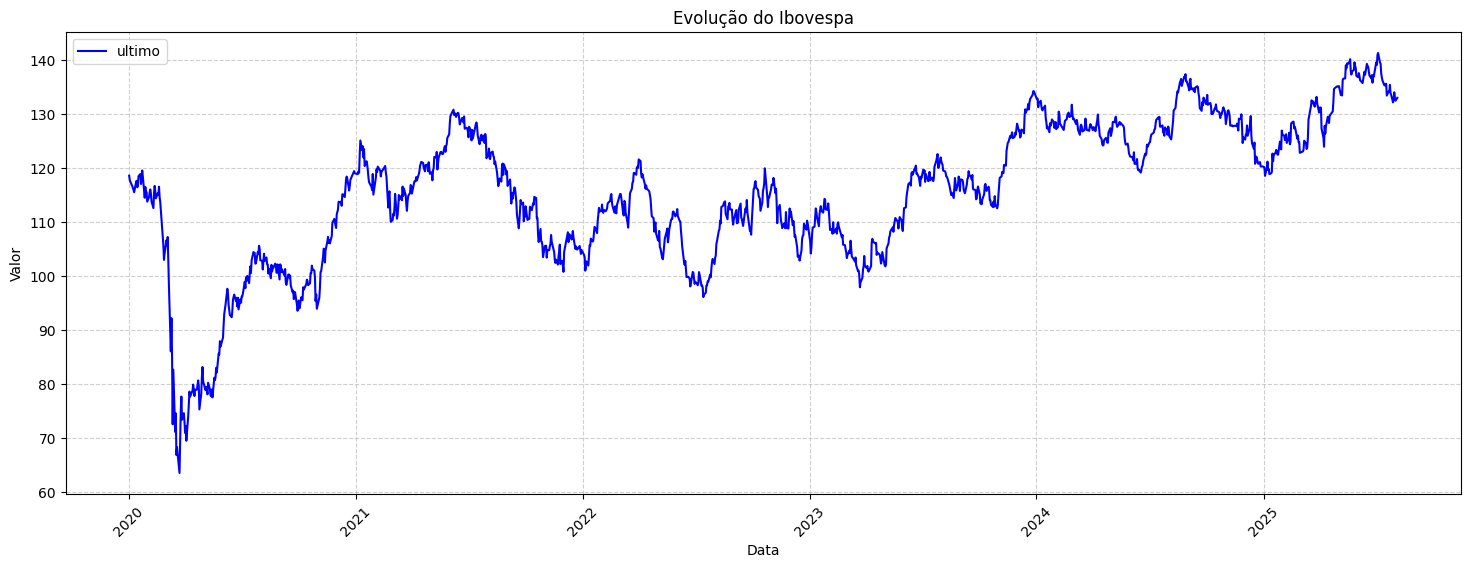

In [408]:
plt.figure(figsize = (18,6))

sns.lineplot(data = df,x='data',y='fechamento', color = 'blue', label = 'ultimo')

plt.title('Evolução do Ibovespa')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.grid(linestyle ='--', alpha = 0.6)
plt.xticks(rotation=45)
plt.legend()

Ao observar o grafico, é possivel notar que os valores da ibovespa apresenta uma tendencia de crescimento por "queda", ou seja, ela vai subindo e caindo, porem com uma tendencia sempre maior que o ano anterior.

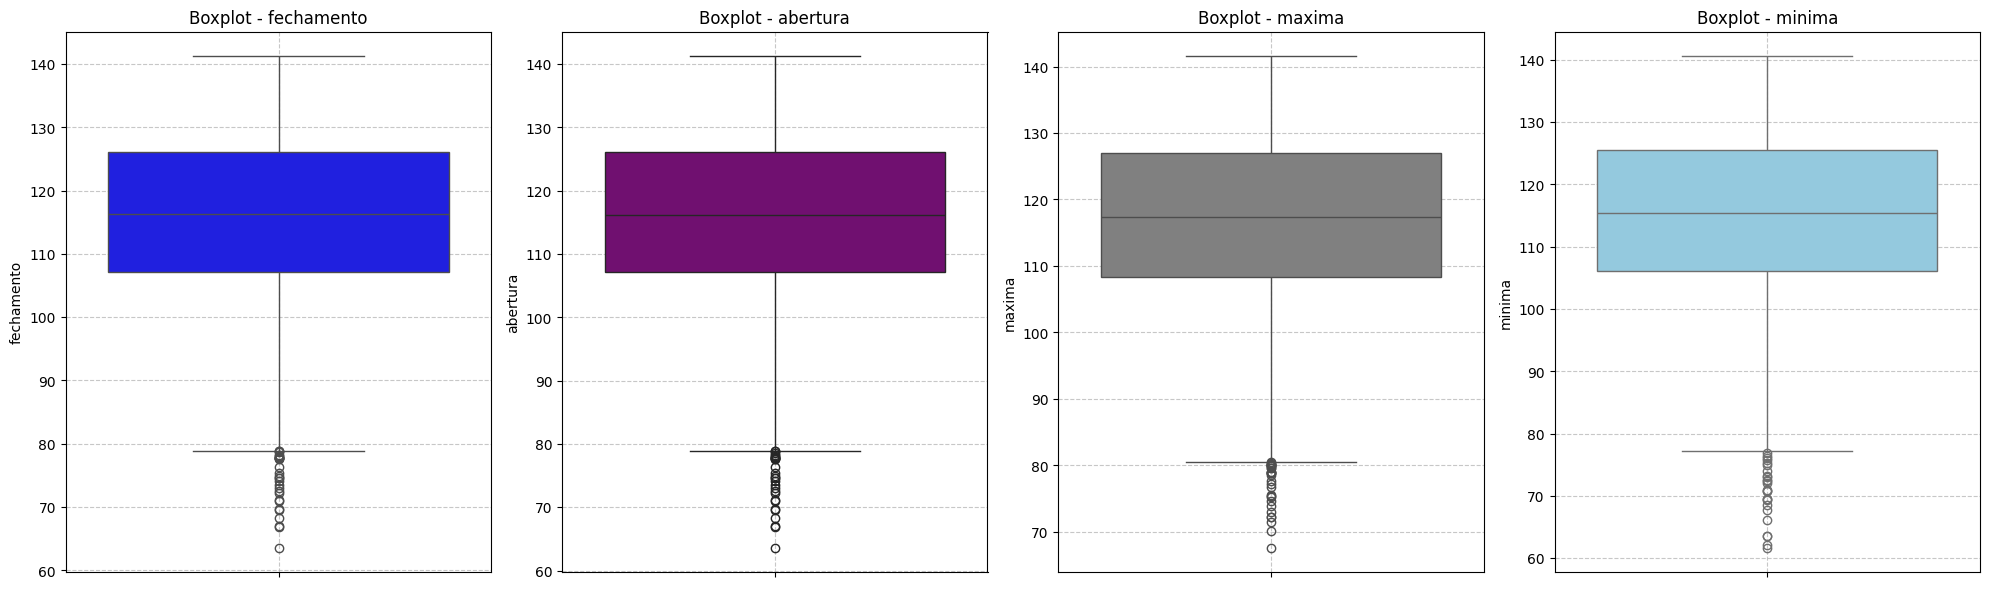

In [409]:
colunas = ['fechamento', 'abertura', 'maxima', 'minima']
color = ['blue', 'purple', 'gray', 'skyblue']

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

for i, coluna in enumerate(colunas):
    sns.boxplot(data=df, y=coluna, ax=axes[i], color=color[i])
    axes[i].set_title(f'Boxplot - {coluna}')
    axes[i].grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Ao observar os boxplots, é possivel notar que não há a presença de poucos outliers para as informações de valores de abertura, minimo e maximo do ibovespa

# Aplicação dos modelos de ML

Para esse desafio, iremos aplicar os seguintes algoritmos:

*   Random forest
*   XGBoosting
*   Regressão logistica

## Criação da coluna target

In [410]:
def avaliar_tendencia(atual, proximo):
    if pd.isna(proximo):
        return None  # última linha não tem próximo
    if proximo < atual:
        return 0  # crescimento
    else:
        return 1  # queda

In [411]:
df['tendencia_fechamento'] = df.apply(
    lambda row: avaliar_tendencia(row['fechamento'], df['fechamento'].shift(1).loc[row.name]),
    axis=1
)

df = df.dropna()

df['tendencia_fechamento'] = df['tendencia_fechamento'].astype(int)

df.head(2)

/tmp/ipython-input-3728917304.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tendencia_fechamento'] = df['tendencia_fechamento'].astype(int)


,data,fechamento,abertura,maxima,minima,vol,var,tendencia_fechamento
1,2025-08-01,132.437,132.920,133.237,132.140,"8,50B",-0.48,1
2,2025-07-31,133.071,133.987,133.987,132.096,"9,20B",-0.69,0


In [412]:
df.groupby('tendencia_fechamento').size()

,0
tendencia_fechamento,
0,681
1,710


In [413]:
# Ano
df['ano'] = df['data'].dt.year

# Mês
df['mes'] = df['data'].dt.month

# Dia do mês
df['dia'] = df['data'].dt.day

# Dia do ano
df['dia_ano'] = df['data'].dt.dayofyear

# Semana do ano
df['semana_ano'] = df['data'].dt.isocalendar().week

/tmp/ipython-input-3221312522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ano'] = df['data'].dt.year
/tmp/ipython-input-3221312522.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mes'] = df['data'].dt.month
/tmp/ipython-input-3221312522.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [414]:
df['fechamento_1'] = df['fechamento'].shift(1)
df['fechamento_2'] = df['fechamento'].shift(2)

df['abertura_1'] = df['abertura'].shift(1)
df['abertura_2'] = df['abertura'].shift(2)

df['maxima_1'] = df['maxima'].shift(1)
df['maxima_2'] = df['maxima'].shift(2)

df['minima_1'] = df['minima'].shift(1)
df['minima_2'] = df['minima'].shift(2)

print(df.shape)
df.head(5)

(1391, 21)


/tmp/ipython-input-3033852771.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fechamento_1'] = df['fechamento'].shift(1)
/tmp/ipython-input-3033852771.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fechamento_2'] = df['fechamento'].shift(2)
/tmp/ipython-input-3033852771.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

,data,fechamento,abertura,maxima,minima,vol,var,tendencia_fechamento,ano,mes,...,dia_ano,semana_ano,fechamento_1,fechamento_2,abertura_1,abertura_2,maxima_1,maxima_2,minima_1,minima_2
1,2025-08-01,132.437,132.920,133.237,132.140,"8,50B",-0.48,1,2025,8,...,213,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-07-31,133.071,133.987,133.987,132.096,"9,20B",-0.69,0,2025,7,...,212,31,132.437,NaN,132.920,NaN,133.237,NaN,132.140,NaN
3,2025-07-30,133.990,132.702,134.368,131.883,"8,66B",0.95,0,2025,7,...,211,31,133.071,132.437,133.987,132.920,133.987,133.237,132.096,132.140
4,2025-07-29,132.726,132.130,133.346,132.130,"6,32B",0.45,1,2025,7,...,210,31,133.990,133.071,132.702,133.987,134.368,133.987,131.883,132.096
5,2025-07-28,132.129,133.538,133.902,131.550,"6,63B",-1.04,1,2025,7,...,209,31,132.726,133.990,132.130,132.702,133.346,134.368,132.130,131.883


In [430]:
df['bb_media'] = df['fechamento_1'].rolling(window=20).mean()
df['bb_std'] = df['fechamento_1'].rolling(window=20).std()

df['bb_superior'] = df['bb_media'] + (2 * df['bb_std'])
df['bb_inferior'] = df['bb_media'] - (2 * df['bb_std'])

df = df.dropna()

df.head(2)

,data,fechamento,abertura,maxima,minima,vol,var,tendencia_fechamento,ano,mes,...,abertura_1,abertura_2,maxima_1,maxima_2,minima_1,minima_2,bb_media,bb_std,bb_superior,bb_inferior
21,2025-07-04,141.264,140.928,141.564,140.597,"3,31B",0.24,0,2025,7,...,141.265,139.491,141.342,139.591,139.295,138.770,134.97335,2.086247,139.145845,130.800855
22,2025-07-03,140.928,139.051,141.304,139.051,"6,08B",1.35,1,2025,7,...,140.928,141.265,141.564,141.342,140.597,139.295,135.41470,2.427253,140.269205,130.560195


## Separação em treino e teste

Iremos testar os codigos com 4 janelas temporais

1.   Dados de jan/2020 até ago/2025
2.   Dados de jan/2021 até ago/2025
3.   Dados de jan/2022 até ago/2025
4.   Dados de jan/2023 até ago/2025


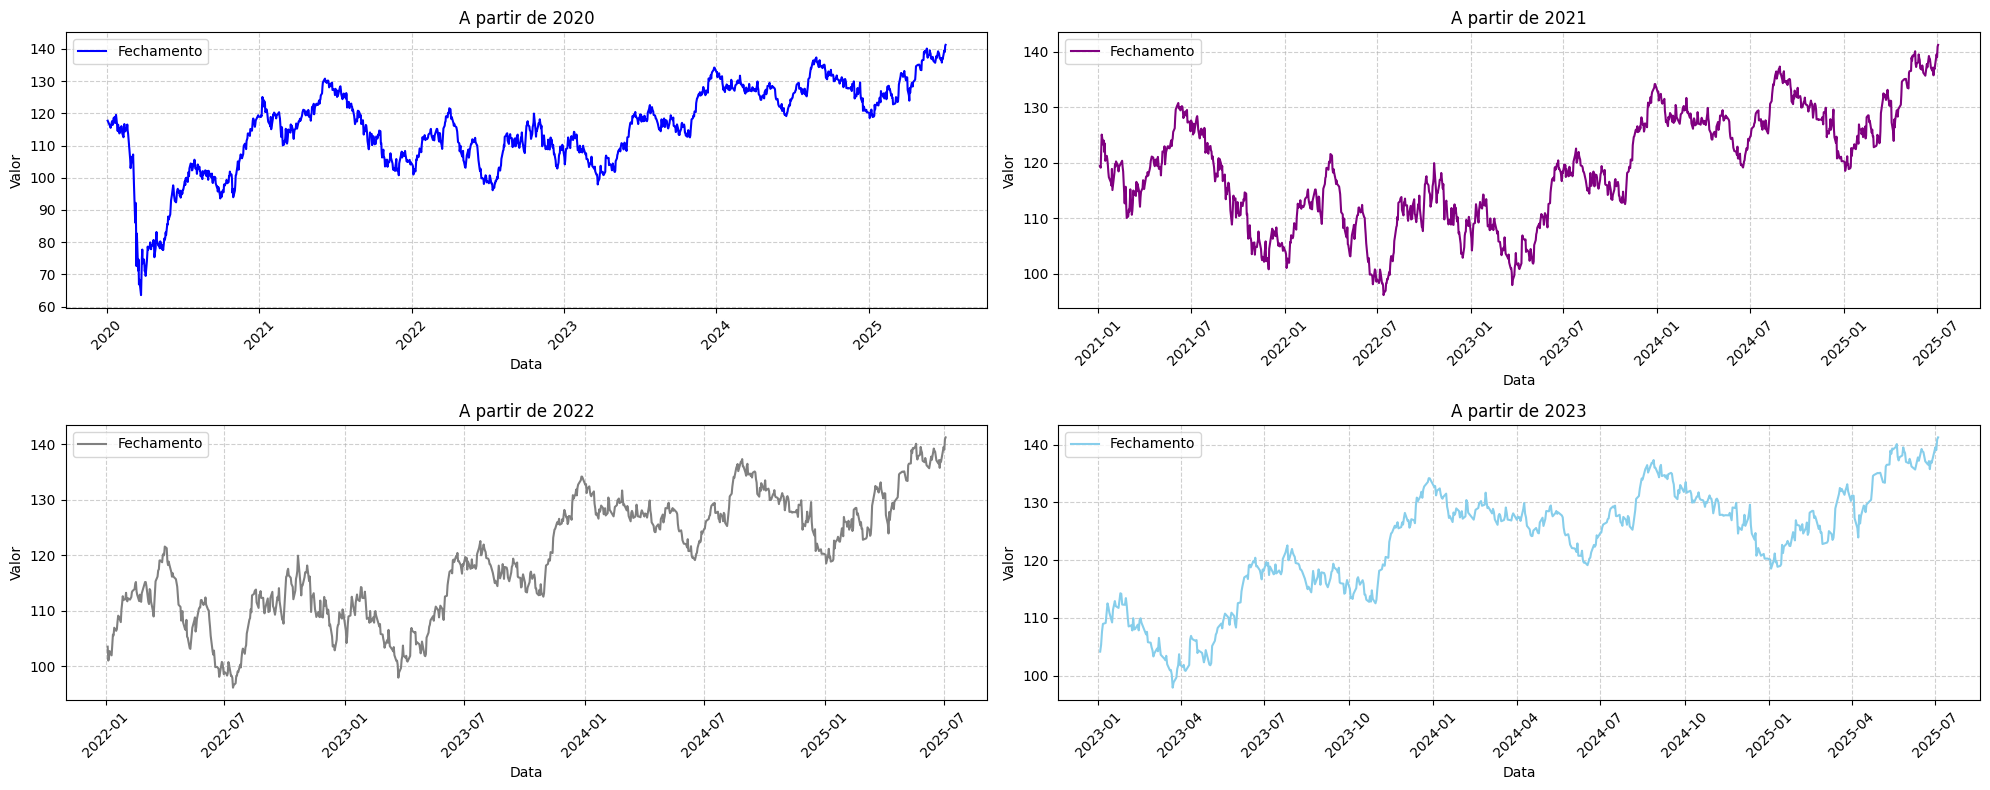

In [449]:
treinos = [df,df[df['data'] >= '2021-01-01'],df[df['data'] >= '2022-01-01'],df[df['data'] >= '2023-01-01']]
titulos = ['A partir de 2020','A partir de 2021','A partir de 2022','A partir de 2023']
color = ['blue', 'purple', 'gray', 'skyblue']

fig, axes = plt.subplots(2, 2, figsize=(20, 8))
axes = axes.flatten()

for i in range(4):
    ax = axes[i]
    sns.lineplot(data=treinos[i],x='data',y=treinos[i]['fechamento_1'].shift(-1),color=color[i],label='Fechamento',ax=ax)
    ax.set_title(titulos[i])
    ax.set_xlabel('Data')
    ax.set_ylabel('Valor')
    ax.legend()
    ax.grid(linestyle='--', alpha=0.6)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [417]:
from sklearn.model_selection import train_test_split

In [432]:
colunas =['ano','mes','dia',
          'dia_ano','semana_ano',
          'fechamento_1','fechamento_2',
          'abertura_1', 'abertura_2',
          'maxima_1', 'maxima_2',
          'minima_1', 'minima_2',
          'bb_media',
          'bb_superior',
          'bb_inferior'
          ]

In [433]:
df_20 = df
df_21 = df[df['data'] >= '2021-01-01']
df_22 = df[df['data'] >= '2022-01-01']
df_23 = df[df['data'] >= '2022-01-01']

In [434]:
# ------------ Janela de 2020 ------------
X_20 = df_20[colunas]
y_20 = df_20['tendencia_fechamento']

X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X_20, y_20, test_size=0.2, shuffle=False)

# ------------ Janela de 2021 ------------
X_21 = df_21[colunas]
y_21 = df_21['tendencia_fechamento']

X_train_21, X_test_21, y_train_21, y_test_21 = train_test_split(X_21, y_21, test_size=0.2, shuffle=False)

# ------------ Janela de 2022 ------------
X_22 = df_22[colunas]
y_22 = df_22['tendencia_fechamento']

X_train_22, X_test_22, y_train_22, y_test_22 = train_test_split(X_22, y_22, test_size=0.2, shuffle=False)

# ------------ Janela de 2023 ------------
X_23 = df_23[colunas]
y_23 = df_23['tendencia_fechamento']

X_train_23, X_test_23, y_train_23, y_test_23 = train_test_split(X_23, y_23, test_size=0.2, shuffle=False)

In [435]:
janelas = [
    {'X_train': X_train_20, 'X_test': X_test_20, 'y_train': y_train_20, 'y_test': y_test_20},
    {'X_train': X_train_21, 'X_test': X_test_21, 'y_train': y_train_21, 'y_test': y_test_21},
    {'X_train': X_train_22, 'X_test': X_test_22, 'y_train': y_train_22, 'y_test': y_test_22},
    {'X_train': X_train_23, 'X_test': X_test_23, 'y_train': y_train_23, 'y_test': y_test_23}
]

janelas_texto = ['Janela de 2020 |','Janela de 2021 |','Janela de 2022 |','Janela de 2023 |']

In [436]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [423]:
modelos_rfc = []
y_preds_rfc = []

for i, base in enumerate(janelas, start=0):
    model_rfc = RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )

    model_rfc.fit(base['X_train'], base['y_train'])
    y_pred = model_rfc.predict(base['X_test'])

    acc = accuracy_score(base['y_test'], y_pred)*100
    print(f"{janelas_texto[i]} Acurácia: {acc:.2f}%")

    modelos_rfc.append(model_rfc)
    y_preds_rfc.append(y_pred)

Janela de 2020 | Acurácia: 70.25%
Janela de 2021 | Acurácia: 79.91%
Janela de 2022 | Acurácia: 78.21%
Janela de 2023 | Acurácia: 78.21%


In [437]:
modelos_xgb = []
y_preds_xgb = []

for i, base in enumerate(janelas, start=0):
    model_xgb = XGBClassifier(
        eval_metric='mlogloss',
        random_state=42,
        learning_rate=0.05,
        n_estimators=300,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1
    )

    model_xgb.fit(base['X_train'], base['y_train'])
    y_pred_xgb = model_xgb.predict(base['X_test'])

    acc = accuracy_score(base['y_test'], y_pred_xgb) * 100
    print(f"{janelas_texto[i]} Acurácia: {acc:.2f}%")

    modelos_xgb.append(model_xgb)
    y_preds_xgb.append(y_pred_xgb)

Janela de 2020 | Acurácia: 76.36%
Janela de 2021 | Acurácia: 90.22%
Janela de 2022 | Acurácia: 78.86%
Janela de 2023 | Acurácia: 78.86%


In [425]:
from sklearn.preprocessing import StandardScaler

In [439]:
modelos_rl = []
y_preds_rl = []

for i, base in enumerate(janelas, start=0):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(base['X_train'])
    X_test_scaled = scaler.transform(base['X_test'])

    model_rl = LogisticRegression(
        max_iter=1000,
        random_state=42
    )

    model_rl.fit(X_train_scaled, base['y_train'])
    y_pred_rl = model_rl.predict(X_test_scaled)

    acc = accuracy_score(base['y_test'], y_pred_rl) * 100
    print(f"{janelas_texto[i]} Acurácia: {acc:.2f}%")

    modelos_rl.append(model_rl)
    y_preds_rl.append(y_pred_rl)

Janela de 2020 | Acurácia: 96.00%
Janela de 2021 | Acurácia: 90.67%
Janela de 2022 | Acurácia: 90.86%
Janela de 2023 | Acurácia: 90.86%


# Avaliando os modelos



## Validação cruzada

In [440]:
from sklearn.model_selection import cross_val_score

In [450]:
# Modelos de XGBoost

# Modelo de 20
scores = cross_val_score(modelos_rfc[0], X_20, y_20, cv=5, scoring='accuracy')*100
print(f"Acurácia média com cross-validation: {scores.mean():.2f} %")

# Modelo de 21
scores = cross_val_score(modelos_rfc[1], X_21, y_21, cv=5, scoring='accuracy')*100
print(f"Acurácia média com cross-validation: {scores.mean():.2f} %")

# Modelo de 22
scores = cross_val_score(modelos_rfc[2], X_20, y_20, cv=5, scoring='accuracy')*100
print(f"Acurácia média com cross-validation: {scores.mean():.2f} %")

# Modelo de 23
scores = cross_val_score(modelos_rfc[3], X_21, y_21, cv=5, scoring='accuracy')*100
print(f"Acurácia média com cross-validation: {scores.mean():.2f} %")

Acurácia média com cross-validation: 73.89 %
Acurácia média com cross-validation: 75.68 %
Acurácia média com cross-validation: 73.89 %
Acurácia média com cross-validation: 75.68 %


In [442]:
# Modelos de XGBoost

# Modelo de 20
scores = cross_val_score(modelos_xgb[0], X_20, y_20, cv=5, scoring='accuracy')*100
print(f"Acurácia média com cross-validation: {scores.mean():.2f} %")

# Modelo de 21
scores = cross_val_score(modelos_xgb[1], X_21, y_21, cv=5, scoring='accuracy')*100
print(f"Acurácia média com cross-validation: {scores.mean():.2f} %")

# Modelo de 22
scores = cross_val_score(modelos_xgb[2], X_20, y_20, cv=5, scoring='accuracy')*100
print(f"Acurácia média com cross-validation: {scores.mean():.2f} %")

# Modelo de 23
scores = cross_val_score(modelos_xgb[3], X_21, y_21, cv=5, scoring='accuracy')*100
print(f"Acurácia média com cross-validation: {scores.mean():.2f} %")

Acurácia média com cross-validation: 80.90 %
Acurácia média com cross-validation: 81.47 %
Acurácia média com cross-validation: 80.90 %
Acurácia média com cross-validation: 81.47 %


In [444]:
# Modelos de regressão logistica

# Modelo de 20
scores = cross_val_score(modelos_rl[0], X_20, y_20, cv=5, scoring='accuracy')*100
print(f"Acurácia média com cross-validation: {scores.mean():.2f} %")

# Modelo de 21
scores = cross_val_score(modelos_rl[1], X_21, y_21, cv=5, scoring='accuracy')*100
print(f"Acurácia média com cross-validation: {scores.mean():.2f} %")

# Modelo de 22
scores = cross_val_score(modelos_rl[2], X_22, y_22, cv=5, scoring='accuracy')*100
print(f"Acurácia média com cross-validation: {scores.mean():.2f} %")

# Modelo de 23
scores = cross_val_score(modelos_rl[3], X_23, y_23, cv=5, scoring='accuracy')*100
print(f"Acurácia média com cross-validation: {scores.mean():.2f} %")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Acurácia média com cross-validation: 98.61 %


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Acurácia média com cross-validation: 98.66 %


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Acurácia média com cross-validation: 98.40 %


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Acurácia média com cross-validation: 98.40 %


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Matriz de confusão

In [445]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

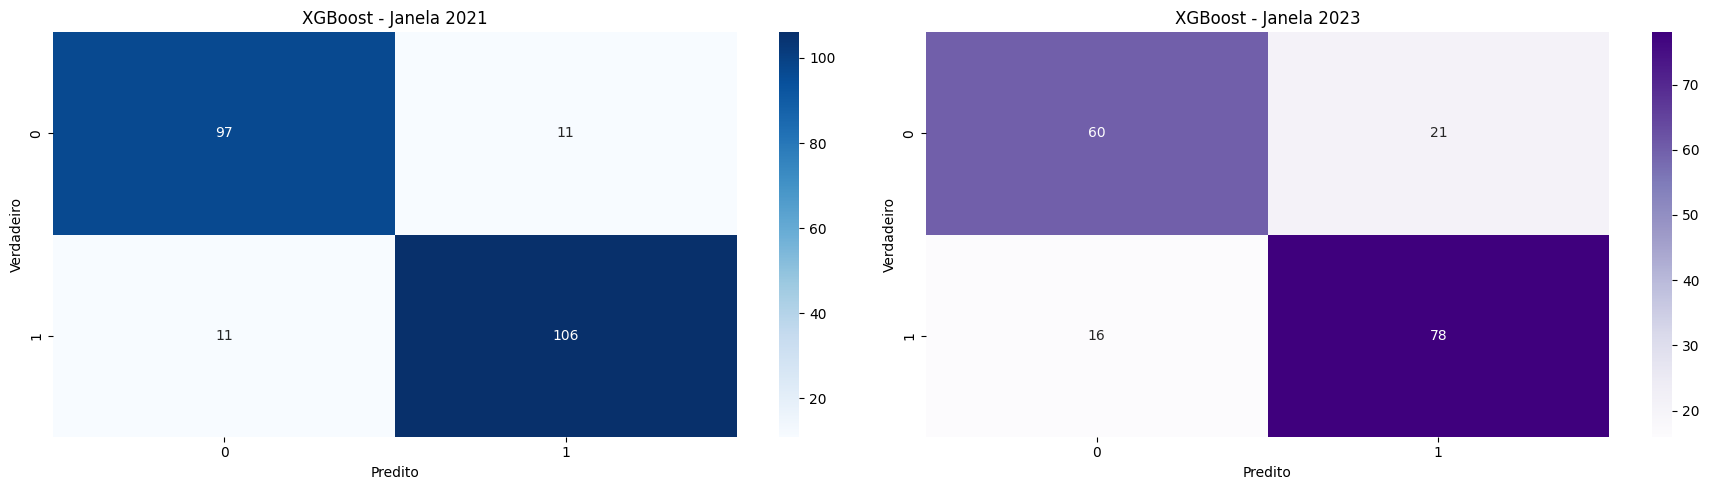

In [463]:
cm_xgb_20 = confusion_matrix(y_test_21, y_preds_xgb[1])
cm_xgb_21 = confusion_matrix(y_test_23, y_preds_xgb[3])

# Cria a figura com 2 subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Matriz de confusão da janela 2020
sns.heatmap(cm_xgb_20, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('XGBoost - Janela 2021')
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Verdadeiro')

# Matriz de confusão da janela 2021
sns.heatmap(cm_xgb_21, annot=True, fmt='d', cmap='Purples', ax=axes[1])
axes[1].set_title('XGBoost - Janela 2023')
axes[1].set_xlabel('Predito')
axes[1].set_ylabel('Verdadeiro')

plt.tight_layout()
plt.show()


In [457]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [464]:
precisao = precision_score(y_test_21,  y_preds_xgb[1])*100
revocacao = recall_score(y_test_21,  y_preds_xgb[1])*100
f1 = f1_score(y_test_21,  y_preds_xgb[1])*100

print(f"Precisão  : {precisao:.2f}%")
print(f"Recall : {revocacao:.2f}%")
print(f"F1-Score  : {f1:.2f}%")

Precisão  : 90.60%
Recall : 90.60%
F1-Score  : 90.60%


In [462]:
precisao = precision_score(y_test_23,  y_preds_xgb[3])*100
revocacao = recall_score(y_test_23,  y_preds_xgb[3])*100
f1 = f1_score(y_test_23,  y_preds_xgb[3])*100

print(f"Precisão  : {precisao:.2f} %")
print(f"Recall : {revocacao:.2f} %")
print(f"F1-Score  : {f1:.2f} %")

Precisão  : 78.79 %
Revocação : 82.98 %
F1-Score  : 80.83 %


## Importancia das features

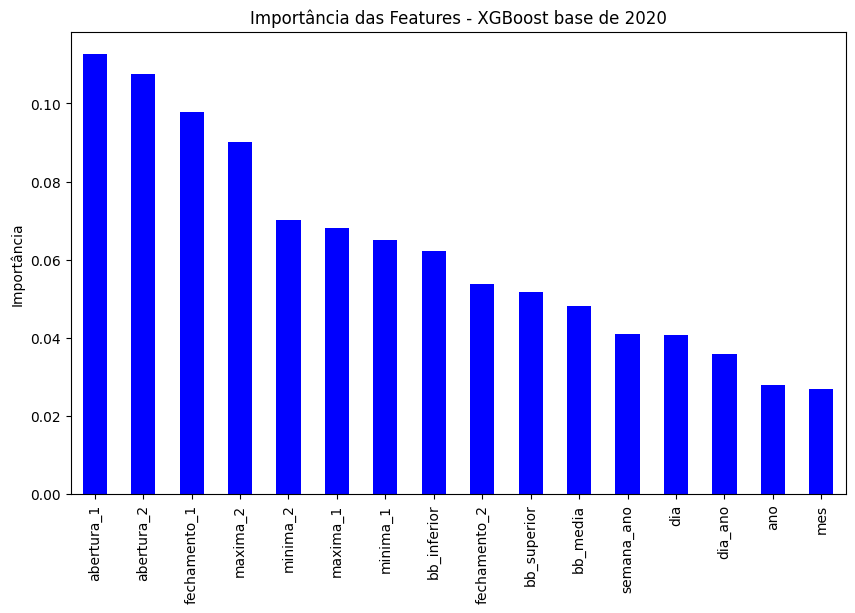

In [455]:
importances_xgb = modelos_xgb[1].feature_importances_
feat_importances_xgb = pd.Series(importances_xgb, index=X_train_21.columns)
feat_importances_xgb = feat_importances_xgb.sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_importances_xgb.plot(kind='bar', color='blue')
plt.title('Importância das Features - XGBoost base de 2020')
plt.ylabel('Importância')
plt.show()

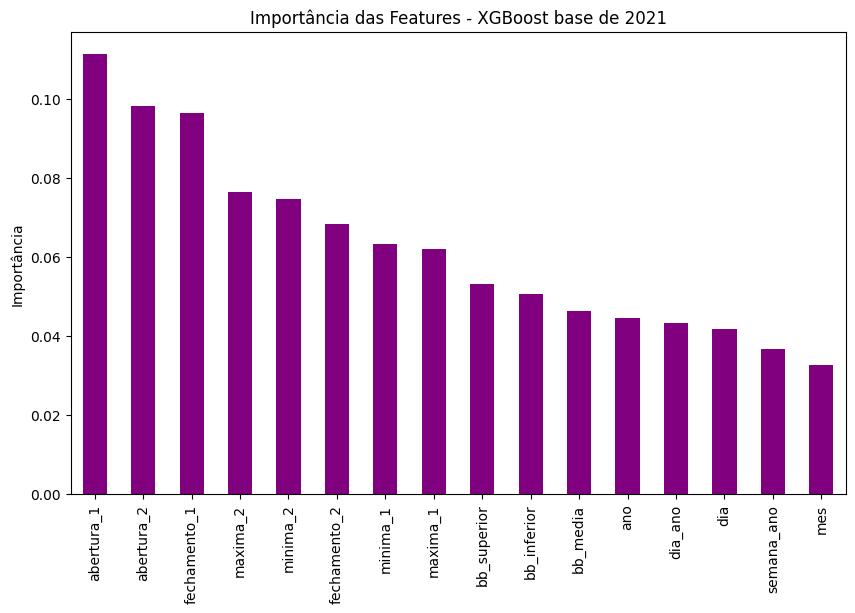

In [454]:
importances_xgb = modelos_xgb[3].feature_importances_
feat_importances_xgb = pd.Series(importances_xgb, index=X_train_23.columns)
feat_importances_xgb = feat_importances_xgb.sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_importances_xgb.plot(kind='bar', color='purple')
plt.title('Importância das Features - XGBoost base de 2021')
plt.ylabel('Importância')
plt.show()